In [5]:
import pandas as pd
import numpy as np
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.utils import resample
from scipy.stats import t


In [6]:
# Load data from CSV files
data = pd.read_csv("/path/to/your/directory/N.2012_ONLY.csv")
income_df = pd.read_csv("/path/to/your/directory/N.covariates.csv", low_memory=False)

# Drop unnecessary columns
data.drop(['hid_x', 'health'], axis=1, inplace=True)

In [7]:
# calculating baseline income for both men and women

# Define the years you want to calculate the CATE for
years = range(2013, 2020)

# Step 1: Filter the 2011 data from the main dataframe
data_2011 = data[data['syear'] == 2011]

# Initialize a list to store individuals present across all years
common_individuals = set(data_2011['pid'])

# Identify individuals present in all years
for year in years:
    income_year = income_df[income_df['syear'] == year]
    common_individuals &= set(income_year['pid'])

# Filter the 2011 data to only include common individuals
data_2011_common = data_2011[data_2011['pid'].isin(common_individuals)]

# Separate data for men and women
data_men = data_2011_common[data_2011_common['sex'] == 1]
data_women = data_2011_common[data_2011_common['sex'] == 2]

# Calculate the baseline mean income for men and women in 2011
baseline_mean_income_men = data_men['gross_income'].mean()
baseline_mean_income_women = data_women['gross_income'].mean()

In [13]:
# CATE estimates for men for Income ovr 2013-2020

# Loop through each year and conduct the analysis separately for women
cate_results_women = {}
cate_results_scaled_women = {}
ci_lowers_women = []
ci_uppers_women = []

for year in years:
    # Step 3: Filter the income data for the given year
    income_year = income_df[income_df['syear'] == year][['pid', 'gross_income']]
    
    # Step 4: Merge the income data with the 2011 data based on 'pid'
    merged_data = pd.merge(data_2011, income_year, on='pid', how='inner', suffixes=('_2011', f'_{year}'))
    
    # Step 5: Separate data for women
    data_women = merged_data[merged_data['sex'] == 2]
    
    # Step 6: Drop rows with missing values for women
    data_women_clean = data_women.dropna(subset=['age_at_survey', 'education', 'hhgr', 'gross_income_2011', 'lf_status', 'binary_treatment', f'gross_income_{year}'])
    
    # Step 7: Define covariates, treatment, and outcome for women
    X_women_clean = data_women_clean[['age_at_survey', 'education', 'hhgr', 'gross_income_2011', 'lf_status']]
    T_women_clean = data_women_clean['binary_treatment']
    y_women_clean = data_women_clean[f'gross_income_{year}']

    # Step 8: Define the models for the outcome and propensity score estimation
    outcome_learner_women = GradientBoostingRegressor(n_estimators=100, random_state=42)
    propensity_learner_women = LogisticRegression(random_state=42)
    
    # Step 9: Instantiate and fit the X-Learner for women
    x_learner_women = XLearner(models=outcome_learner_women, propensity_model=propensity_learner_women)
    x_learner_women.fit(y_women_clean, T_women_clean, X=X_women_clean)
    
    # Step 10: Estimate the Conditional Average Treatment Effect (CATE) for women
    cate_estimates_women = x_learner_women.effect(X_women_clean)
    
    # Step 11: Scale the CATE estimates by the baseline mean income for women
    cate_estimates_scaled_women = cate_estimates_women / baseline_mean_income_women
    
    # Step 12: Store the results for each year
    cate_results_women[year] = cate_estimates_women
    cate_results_scaled_women[year] = cate_estimates_scaled_women

    # Output the CATE estimates for women for the year
    print(f"CATE Estimates for Women in {year}:")
    print(cate_estimates_women)
    print(f"Scaled CATE Estimates for Women in {year}:")
    print(cate_estimates_scaled_women)

    # Step 13: Perform bootstrapping to calculate confidence intervals and standard errors
    def bootstrap_cate(X, T, y, x_learner):
        X_resampled, T_resampled, y_resampled = resample(X, T, y)
        x_learner.fit(y_resampled, T_resampled, X=X_resampled)
        return np.mean(x_learner.effect(X_resampled))

    n_bootstraps = 200  # Adjust this as needed
    bootstrapped_cates_women = Parallel(n_jobs=-1)(delayed(bootstrap_cate)(X_women_clean, T_women_clean, y_women_clean, x_learner_women) for _ in range(n_bootstraps))

    # Calculate confidence intervals and standard error for scaled estimates
    ci_lower_women = np.percentile(bootstrapped_cates_women, 2.5) / baseline_mean_income_women
    ci_upper_women = np.percentile(bootstrapped_cates_women, 97.5) / baseline_mean_income_women
    
    # Store the confidence intervals for women
    ci_lowers_women.append(ci_lower_women)
    ci_uppers_women.append(ci_upper_women)

    print(f"95% Confidence Interval for Women in {year}: [{ci_lower_women}, {ci_upper_women}]")


CATE Estimates for Women in 2013:
[ -58.78575811 -300.50659334 -233.43570361 ...  -24.64649446  -78.65321597
 -157.63653652]
Scaled CATE Estimates for Women in 2013:
[-0.02405604 -0.12297196 -0.09552551 ... -0.01008573 -0.03218612
 -0.06450732]
95% Confidence Interval for Women in 2013: [-0.06713405980142986, -0.0009641985818828801]
CATE Estimates for Women in 2014:
[-266.70647668 -305.76364884 -181.94288647 ...  -11.92341479 -278.35560615
    1.85918863]
Scaled CATE Estimates for Women in 2014:
[-0.10914043 -0.12512323 -0.07445385 ... -0.00487925 -0.11390743
  0.00076081]
95% Confidence Interval for Women in 2014: [-0.11251125633176394, -0.03144582900350833]
CATE Estimates for Women in 2015:
[-165.22491948    9.22890759  604.00491651 ...   55.36700515  -44.04433468
  -83.09872266]
Scaled CATE Estimates for Women in 2015:
[-0.0676126   0.00377661  0.24716819 ...  0.02265704 -0.01802363
 -0.03400529]
95% Confidence Interval for Women in 2015: [-0.08879998593995367, 0.01097342011938522]


In [14]:
# CATE estimates for men for Income ovr 2013-2020

# Step 2: Loop through each year and conduct the analysis separately for men
cate_results_men = {}
cate_results_scaled_men = {}
ci_lowers_men = []
ci_uppers_men = []

for year in years:
    # Step 3: Filter the income data for the given year
    income_year = income_df[income_df['syear'] == year][['pid', 'gross_income']]
    
    # Step 4: Merge the income data with the 2011 data based on 'pid'
    merged_data = pd.merge(data_2011, income_year, on='pid', how='inner', suffixes=('_2011', f'_{year}'))
    
    # Step 5: Separate data for men
    data_men = merged_data[merged_data['sex'] == 1]
    
    # Step 6: Drop rows with missing values for men
    data_men_clean = data_men.dropna(subset=['age_at_survey', 'education', 'hhgr', 'gross_income_2011', 'lf_status', 'binary_treatment', f'gross_income_{year}'])
    
    # Step 7: Define covariates, treatment, and outcome for men
    X_men_clean = data_men_clean[['age_at_survey', 'education', 'hhgr', 'gross_income_2011', 'lf_status']]
    T_men_clean = data_men_clean['binary_treatment']
    y_men_clean = data_men_clean[f'gross_income_{year}']

    # Step 8: Define the models for the outcome and propensity score estimation
    outcome_learner_men = GradientBoostingRegressor(n_estimators=100, random_state=42)
    propensity_learner_men = LogisticRegression(random_state=42)
    
    # Step 9: Instantiate and fit the X-Learner for men
    x_learner_men = XLearner(models=outcome_learner_men, propensity_model=propensity_learner_men)
    x_learner_men.fit(y_men_clean, T_men_clean, X=X_men_clean)
    
    # Step 10: Estimate the Conditional Average Treatment Effect (CATE) for men
    cate_estimates_men = x_learner_men.effect(X_men_clean)
    
    # Step 11: Scale the CATE estimates by the baseline mean income for men
    cate_estimates_scaled_men = cate_estimates_men / baseline_mean_income_men
    
    # Step 12: Store the results for each year
    cate_results_men[year] = cate_estimates_men
    cate_results_scaled_men[year] = cate_estimates_scaled_men

    # Output the CATE estimates for men for the year
    print(f"CATE Estimates for Men in {year}:")
    print(cate_estimates_men)
    print(f"Scaled CATE Estimates for Men in {year}:")
    print(cate_estimates_scaled_men)

    # Step 13: Perform bootstrapping to calculate confidence intervals
    def bootstrap_cate(X, T, y, x_learner):
        X_resampled, T_resampled, y_resampled = resample(X, T, y)
        x_learner.fit(y_resampled, T_resampled, X=X_resampled)
        return np.mean(x_learner.effect(X_resampled))

    n_bootstraps = 200  # Adjust this as needed
    bootstrapped_cates_men = Parallel(n_jobs=-1)(delayed(bootstrap_cate)(X_men_clean, T_men_clean, y_men_clean, x_learner_men) for _ in range(n_bootstraps))

    # Calculate confidence intervals and standard error for scaled estimates
    ci_lower_men = np.percentile(bootstrapped_cates_men, 2.5) / baseline_mean_income_men
    ci_upper_men = np.percentile(bootstrapped_cates_men, 97.5) / baseline_mean_income_men
    
    # Store the confidence intervals for men
    ci_lowers_men.append(ci_lower_men)
    ci_uppers_men.append(ci_upper_men)

    print(f"95% Confidence Interval for Men in {year}: [{ci_lower_men}, {ci_upper_men}]")


CATE Estimates for Men in 2013:
[-974.32142061  124.26650086   18.88132348 ...   27.16935834   80.72270488
  -48.58488493]
Scaled CATE Estimates for Men in 2013:
[-0.25975613  0.03312971  0.0050338  ...  0.00724341  0.02152084
 -0.01295283]
95% Confidence Interval for Men in 2013: [-0.03377972427355496, 0.03721728063166775]
CATE Estimates for Men in 2014:
[-827.86996231 -109.96556603  495.63140826 ... -142.31579316   31.80761007
  -18.5056844 ]
Scaled CATE Estimates for Men in 2014:
[-0.22071186 -0.02931705  0.13213637 ... -0.03794169  0.00847998
 -0.00493365]
95% Confidence Interval for Men in 2014: [-0.06148875300615311, 0.01707309712678941]
CATE Estimates for Men in 2015:
[-107.59421918 -109.17787411  651.26797176 ... -296.1943609     7.41192043
  107.72240171]
Scaled CATE Estimates for Men in 2015:
[-0.02868484 -0.02910705  0.1736294  ... -0.07896604  0.00197603
  0.02871902]
95% Confidence Interval for Men in 2015: [-0.07041838481318081, -0.003922775533363877]
CATE Estimates for M

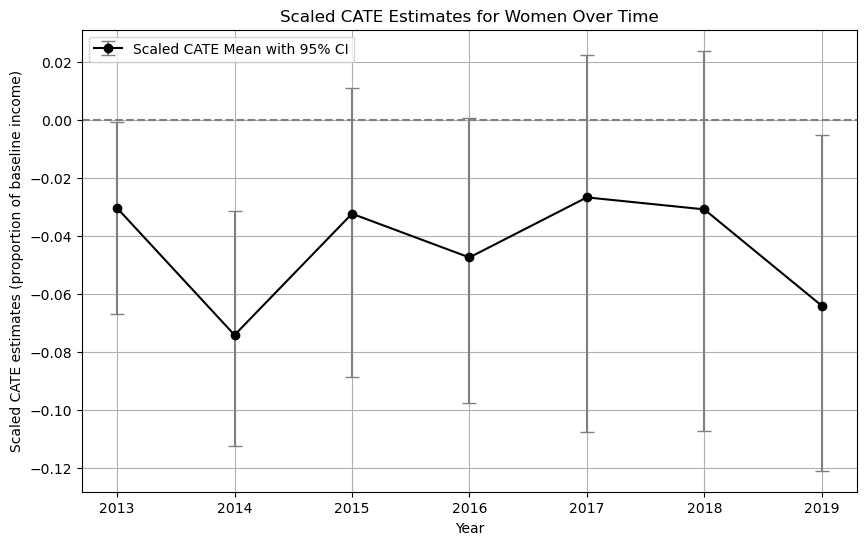

In [15]:
# plotting the CATE estimates for women over time

def plot_cate_women(years, cate_results_scaled_women, ci_lowers_women, ci_uppers_women):
    # Calculate the mean of the scaled CATE estimates for each year
    mean_cates_scaled_women = [np.mean(cate_results_scaled_women[year]) for year in years]

    # Convert lists to numpy arrays for easy calculation of error bars
    years = np.array(list(years))
    mean_cates_scaled_women = np.array(mean_cates_scaled_women)
    ci_lowers_women = np.array(ci_lowers_women)
    ci_uppers_women = np.array(ci_uppers_women)

    # Calculate the error margins
    error_bars_women = [mean_cates_scaled_women - ci_lowers_women, ci_uppers_women - mean_cates_scaled_women]

    # Plotting the results with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(years, mean_cates_scaled_women, yerr=error_bars_women, fmt='o-', color='black', ecolor='gray', capsize=5, label='Scaled CATE Mean with 95% CI')
    plt.axhline(0, color='gray', linestyle='--')

    plt.xlabel('Year')
    plt.ylabel('Scaled CATE estimates (proportion of baseline income)')
    plt.title('Scaled CATE Estimates for Women Over Time')
    plt.xticks(years)
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot for women
plot_cate_women(years, cate_results_scaled_women, ci_lowers_women, ci_uppers_women)


In [19]:
# Calculate and print the mean of the scaled CATE estimates for women for each year
mean_cates_scaled_women = {}

for year in years:
    mean_cate = np.mean(cate_results_scaled_women[year])
    mean_cates_scaled_women[year] = mean_cate
    print(f"Year {year}: Mean Scaled CATE for Women = {mean_cate}")

# Now `mean_cates_scaled_women` will contain the mean CATE estimates for each year


Year 2013: Mean Scaled CATE for Women = -0.03046608989634602
Year 2014: Mean Scaled CATE for Women = -0.07421179890231569
Year 2015: Mean Scaled CATE for Women = -0.032414473506767384
Year 2016: Mean Scaled CATE for Women = -0.04748053784989716
Year 2017: Mean Scaled CATE for Women = -0.026780456058755467
Year 2018: Mean Scaled CATE for Women = -0.030910555938575536
Year 2019: Mean Scaled CATE for Women = -0.06410582178631806


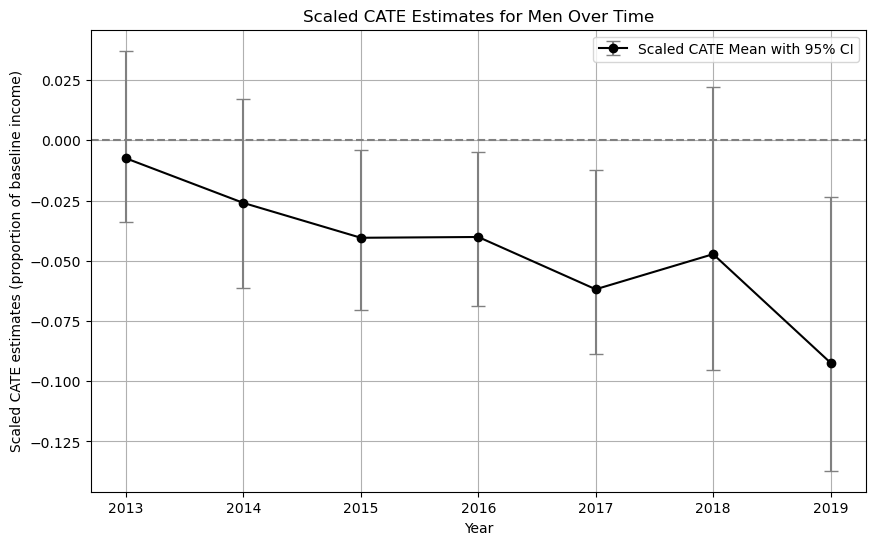

In [16]:
# plotting the CATE estimates for men over time

def plot_cate_men(years, cate_results_scaled_men, ci_lowers_men, ci_uppers_men):
    # Calculate the mean of the scaled CATE estimates for each year
    mean_cates_scaled_men = [np.mean(cate_results_scaled_men[year]) for year in years]

    # Convert lists to numpy arrays for easy calculation of error bars
    years = np.array(list(years))
    mean_cates_scaled_men = np.array(mean_cates_scaled_men)
    ci_lowers_men = np.array(ci_lowers_men)
    ci_uppers_men = np.array(ci_uppers_men)

    # Calculate the error margins
    error_bars_men = [mean_cates_scaled_men - ci_lowers_men, ci_uppers_men - mean_cates_scaled_men]

    # Plotting the results with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(years, mean_cates_scaled_men, yerr=error_bars_men, fmt='o-', color='black', ecolor='gray', capsize=5, label='Scaled CATE Mean with 95% CI')
    plt.axhline(0, color='gray', linestyle='--')

    plt.xlabel('Year')
    plt.ylabel('Scaled CATE estimates (proportion of baseline income)')
    plt.title('Scaled CATE Estimates for Men Over Time')
    plt.xticks(years)
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot for men
plot_cate_men(years, cate_results_scaled_men, ci_lowers_men, ci_uppers_men)


In [20]:
# Calculate and print the mean of the scaled CATE estimates for men for each year
mean_cates_scaled_men = {}

for year in years:
    mean_cate = np.mean(cate_results_scaled_men[year])
    mean_cates_scaled_men[year] = mean_cate
    print(f"Year {year}: Mean Scaled CATE for men = {mean_cate}")

# Now `mean_cates_scaled_women` will contain the mean CATE estimates for each year


Year 2013: Mean Scaled CATE for men = -0.0074598864283670786
Year 2014: Mean Scaled CATE for men = -0.025979183123442474
Year 2015: Mean Scaled CATE for men = -0.040442067380868536
Year 2016: Mean Scaled CATE for men = -0.0401148893196514
Year 2017: Mean Scaled CATE for men = -0.061826299724013205
Year 2018: Mean Scaled CATE for men = -0.047245508953720844
Year 2019: Mean Scaled CATE for men = -0.09233919345780477


In [17]:
# Calculate the t-values and p-values for the CATE estimates for men

t_values_men = []
p_values_men = []

for year in years:
    # Use the scaled CATE results and standard error you already calculated
    mean_cate_scaled_men = np.mean(cate_results_scaled_men[year])
    std_error_men = (ci_uppers_men[years.index(year)] - ci_lowers_men[years.index(year)]) / (2 * 1.96)

    # Calculate the t-value for the scaled CATE estimates
    t_value_men = mean_cate_scaled_men / std_error_men
    t_values_men.append(t_value_men)

    # Calculate the p-value using the t-distribution
    p_value_men = 2 * (1 - t.cdf(abs(t_value_men), df=len(cate_results_scaled_men[year]) - 1))
    p_values_men.append(p_value_men)

    print(f"t-value for Men in {year}: {t_value_men}")
    print(f"p-value for Men in {year}: {p_value_men}")


t-value for Men in 2013: -0.41188716113076174
p-value for Men in 2013: 0.6804445034753956
t-value for Men in 2014: -1.2962830899675015
p-value for Men in 2014: 0.19496387884539046
t-value for Men in 2015: -2.3841108585965443
p-value for Men in 2015: 0.01717879882415585
t-value for Men in 2016: -2.4560491461288656
p-value for Men in 2016: 0.01410685112230814
t-value for Men in 2017: -3.170320096385504
p-value for Men in 2017: 0.001540222112759393
t-value for Men in 2018: -1.5786280647938435
p-value for Men in 2018: 0.11455495702722818
t-value for Men in 2019: -3.1812963910422862
p-value for Men in 2019: 0.0014878613339330826


In [18]:
# Calculate the t-values and p-values for the CATE estimates for women

t_values_women = []
p_values_women = []

for year in years:
    # Use the scaled CATE results and standard error you already calculated
    mean_cate_scaled_women = np.mean(cate_results_scaled_women[year])
    std_error_women = (ci_uppers_women[years.index(year)] - ci_lowers_women[years.index(year)]) / (2 * 1.96)

    # Calculate the t-value for the scaled CATE estimates
    t_value_women = mean_cate_scaled_women / std_error_women
    t_values_women.append(t_value_women)

    # Calculate the p-value using the t-distribution
    p_value_women = 2 * (1 - t.cdf(abs(t_value_women), df=len(cate_results_scaled_women[year]) - 1))
    p_values_women.append(p_value_women)

    print(f"t-value for Women in {year}: {t_value_women}")
    print(f"p-value for Women in {year}: {p_value_women}")

t-value for Women in 2013: -1.8048560204384545
p-value for Women in 2013: 0.07125032411488208
t-value for Women in 2014: -3.5885859272548335
p-value for Women in 2014: 0.0003417679744426305
t-value for Women in 2015: -1.2735331103255922
p-value for Women in 2015: 0.20301696571322814
t-value for Women in 2016: -1.8952377068891901
p-value for Women in 2016: 0.058260199117948996
t-value for Women in 2017: -0.8084746910771967
p-value for Women in 2017: 0.41896206589087326
t-value for Women in 2018: -0.925686495632395
p-value for Women in 2018: 0.35479520272156684
t-value for Women in 2019: -2.1695910960704987
p-value for Women in 2019: 0.030249471200052058


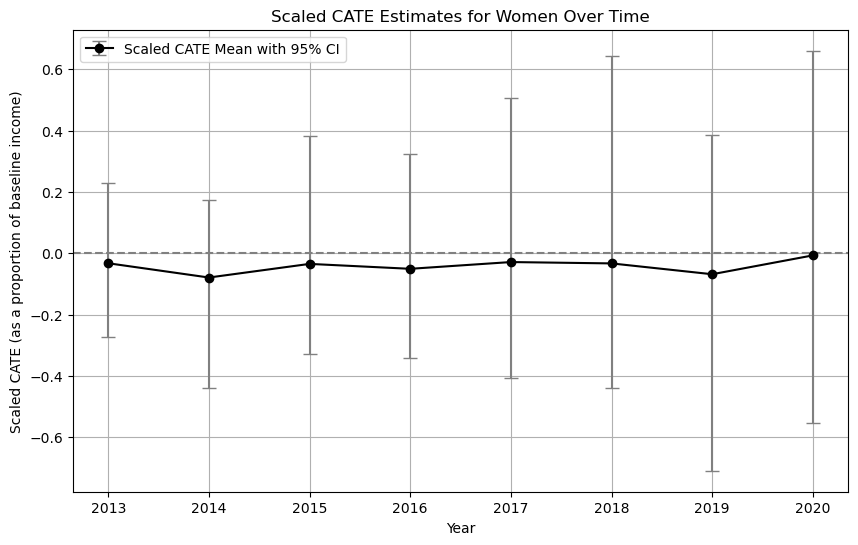

In [21]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Convert years to a list
# years = list(cate_results_scaled_women.keys())

# # Calculate the mean of the scaled CATE estimates for each year
# mean_cates_scaled_women = [np.mean(cate_results_scaled_women[year]) for year in years]

# # Calculate the confidence intervals for each year
# ci_lowers_women = []
# ci_uppers_women = []
# for year in years:
#     bootstrapped_cates_women = cate_results_scaled_women[year]
#     ci_lower_women = np.percentile(bootstrapped_cates_women, 2.5)
#     ci_upper_women = np.percentile(bootstrapped_cates_women, 97.5)
#     ci_lowers_women.append(ci_lower_women)
#     ci_uppers_women.append(ci_upper_women)

# # Convert lists to numpy arrays for easy calculation of error bars
# years = np.array(years)
# mean_cates_scaled_women = np.array(mean_cates_scaled_women)
# ci_lowers_women = np.array(ci_lowers_women)
# ci_uppers_women = np.array(ci_uppers_women)

# # Calculate the error margins
# error_bars_women = [mean_cates_scaled_women - ci_lowers_women, ci_uppers_women - mean_cates_scaled_women]

# # Plotting the results with error bars
# plt.figure(figsize=(10, 6))
# plt.errorbar(years, mean_cates_scaled_women, yerr=error_bars_women, fmt='o-', color='black', ecolor='gray', capsize=5, label='Scaled CATE Mean with 95% CI')
# plt.axhline(0, color='gray', linestyle='--')

# plt.xlabel('Year')
# plt.ylabel('Scaled CATE (as a proportion of baseline income)')
# plt.title('Scaled CATE Estimates for Women Over Time')
# plt.xticks(years)
# plt.grid(True)
# plt.legend()
# plt.show()


In [23]:
# from joblib import Parallel, delayed
# from sklearn.utils import resample
# import numpy as np
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.linear_model import LogisticRegression
# from econml.metalearners import XLearner

# # Step 1: Filter the 2011 data from the main dataframe
# data_2011 = data[data['syear'] == 2011]

# # Calculate the baseline mean income for men in 2011
# baseline_mean_income_men = data_2011[data_2011['sex'] == 1]['gross_income'].mean()

# # Step 2: Loop through each year and conduct the analysis separately for men
# years = range(2013, 2021)

# cate_results_men = {}
# cate_results_scaled_men = {}

# for year in years:
#     # Step 3: Filter the income data for the given year
#     income_year = income_df[income_df['syear'] == year][['pid', 'gross_income']]
    
#     # Step 4: Merge the income data with the 2011 data based on 'pid'
#     merged_data = pd.merge(data_2011, income_year, on='pid', how='inner', suffixes=('_2011', f'_{year}'))
    
#     # Step 5: Separate data for men
#     data_men = merged_data[merged_data['sex'] == 1]
    
#     # Step 6: Drop rows with missing values for men
#     data_men_clean = data_men.dropna(subset=['age_at_survey', 'education', 'hhgr', 'gross_income_2011', 'lf_status', 'binary_treatment', f'gross_income_{year}'])
    
#     # Step 7: Define covariates, treatment, and outcome for men
#     X_men_clean = data_men_clean[['age_at_survey', 'education', 'hhgr', 'gross_income_2011', 'lf_status']]
#     T_men_clean = data_men_clean['binary_treatment']
#     y_men_clean = data_men_clean[f'gross_income_{year}']

#     # Step 8: Define the models for the outcome and propensity score estimation
#     outcome_learner_men = GradientBoostingRegressor(n_estimators=100, random_state=42)
#     propensity_learner_men = LogisticRegression(random_state=42)
    
#     # Step 9: Instantiate and fit the X-Learner for men
#     x_learner_men = XLearner(models=outcome_learner_men, propensity_model=propensity_learner_men)
#     x_learner_men.fit(y_men_clean, T_men_clean, X=X_men_clean)
    
#     # Step 10: Estimate the Conditional Average Treatment Effect (CATE) for men
#     cate_estimates_men = x_learner_men.effect(X_men_clean)
    
#     # Step 11: Scale the CATE estimates by the baseline mean income for men
#     cate_estimates_scaled_men = cate_estimates_men / baseline_mean_income_men
    
#     # Step 12: Store the results for each year
#     cate_results_men[year] = cate_estimates_men
#     cate_results_scaled_men[year] = cate_estimates_scaled_men

#     # Output the CATE estimates for men for the year
#     print(f"CATE Estimates for Men in {year}:")
#     print(cate_estimates_men)
#     print(f"Scaled CATE Estimates for Men in {year}:")
#     print(cate_estimates_scaled_men)

#     # Step 13: Perform bootstrapping to calculate confidence intervals and standard errors
#     def bootstrap_cate(X, T, y, x_learner):
#         X_resampled, T_resampled, y_resampled = resample(X, T, y)
#         x_learner.fit(y_resampled, T_resampled, X=X_resampled)
#         return np.mean(x_learner.effect(X_resampled))

#     n_bootstraps = 200  # Adjust this as needed
#     bootstrapped_cates_men = Parallel(n_jobs=-1)(delayed(bootstrap_cate)(X_men_clean, T_men_clean, y_men_clean, x_learner_men) for _ in range(n_bootstraps))

#     # Calculate confidence intervals and standard error for scaled estimates
#     ci_lower = np.percentile(bootstrapped_cates_men, 2.5) / baseline_mean_income_men
#     ci_upper = np.percentile(bootstrapped_cates_men, 97.5) / baseline_mean_income_men
#     std_error = np.std(bootstrapped_cates_men) / baseline_mean_income_men

#     print(f"95% Confidence Interval for Men in {year}: [{ci_lower}, {ci_upper}]")
#     print(f"Standard Error for Men in {year}: {std_error}")


CATE Estimates for Men in 2013:
[-974.32142061  124.26650086   18.88132348 ...   27.16935834   80.72270488
  -48.58488493]
Scaled CATE Estimates for Men in 2013:
[-0.26894007  0.03430104  0.00521178 ...  0.00749951  0.02228173
 -0.01341079]
95% Confidence Interval for Men in 2013: [-0.04114727388516454, 0.036060904858417564]
Standard Error for Men in 2013: 0.020019557874612914
CATE Estimates for Men in 2014:
[-827.86996231 -109.96556603  495.63140826 ... -142.31579316   31.80761007
  -18.5056844 ]
Scaled CATE Estimates for Men in 2014:
[-0.22851535 -0.03035358  0.13680818 ... -0.03928315  0.00877979
 -0.00510809]
95% Confidence Interval for Men in 2014: [-0.062083360793215685, 0.023512329107064363]
Standard Error for Men in 2014: 0.020473041908037656
CATE Estimates for Men in 2015:
[-107.59421918 -109.17787411  651.26797176 ... -296.1943609     7.41192043
  107.72240171]
Scaled CATE Estimates for Men in 2015:
[-0.02969903 -0.03013616  0.17976825 ... -0.08175796  0.0020459
  0.02973441]

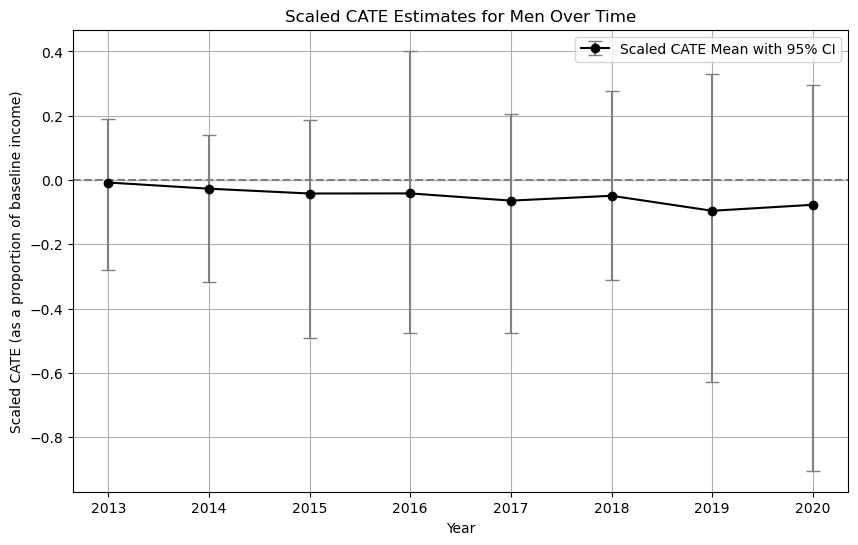

In [24]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Convert years to a list
# years = list(cate_results_scaled_men.keys())

# # Calculate the mean of the scaled CATE estimates for each year
# mean_cates_scaled_men = [np.mean(cate_results_scaled_men[year]) for year in years]

# # Calculate the confidence intervals for each year
# ci_lowers_men = []
# ci_uppers_men = []
# for year in years:
#     bootstrapped_cates_men = cate_results_scaled_men[year]
#     ci_lower_men = np.percentile(bootstrapped_cates_men, 2.5)
#     ci_upper_men = np.percentile(bootstrapped_cates_men, 97.5)
#     ci_lowers_men.append(ci_lower_men)
#     ci_uppers_men.append(ci_upper_men)

# # Convert lists to numpy arrays for easy calculation of error bars
# years = np.array(years)
# mean_cates_scaled_men = np.array(mean_cates_scaled_men)
# ci_lowers_men = np.array(ci_lowers_men)
# ci_uppers_men = np.array(ci_uppers_men)

# # Calculate the error margins
# error_bars_men = [mean_cates_scaled_men - ci_lowers_men, ci_uppers_men - mean_cates_scaled_men]

# # Plotting the results with error bars
# plt.figure(figsize=(10, 6))
# plt.errorbar(years, mean_cates_scaled_men, yerr=error_bars_men, fmt='o-', color='black', ecolor='gray', capsize=5, label='Scaled CATE Mean with 95% CI')
# plt.axhline(0, color='gray', linestyle='--')

# plt.xlabel('Year')
# plt.ylabel('Scaled CATE (as a proportion of baseline income)')
# plt.title('Scaled CATE Estimates for Men Over Time')
# plt.xticks(years)
# plt.grid(True)
# plt.legend()
# plt.show()
